# Module 7 — Unsupervised Learning

**Goals for this notebook**
- Understand what unsupervised learning is and why it is useful.
- Practice three clustering approaches: **K-Means**, **DBSCAN**, and **Hierarchical (Agglomerative)**.
- Use **PCA** as a helper for visualization and noise reduction.
- Interpret cluster results with simple internal validation metrics.

**By the end**, you should be able to: describe the methods at a high level, choose sensible parameters, and interpret clusters on a student-feel dataset.


## 1) Build a sensible, feelable dataset
We synthesize a small dataset that resembles student life patterns.

**Features**
- `StudyHours` per week
- `Attendance` percent
- `SleepHours` per night
- `LibraryVisits` per week
- `CafeSpend` dollars per week

We will generate a few latent profiles plus noise, so clusters are present but not trivial.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# For dendrogram
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

np.random.seed(42)

# Latent profiles
n_per = 70
# High-commitment: high study, high attendance, moderate sleep, more library, moderate cafe spend
hc = np.column_stack([
    np.random.normal(10, 1.2, n_per),   # StudyHours
    np.random.normal(92, 3.0, n_per),   # Attendance
    np.random.normal(7.5, 0.6, n_per),  # SleepHours
    np.random.normal(4.5, 1.2, n_per),  # LibraryVisits
    np.random.normal(35, 7.0, n_per)    # CafeSpend
])

# Balanced: moderate everything
bal = np.column_stack([
    np.random.normal(7, 1.3, n_per),
    np.random.normal(85, 5.0, n_per),
    np.random.normal(7.0, 0.7, n_per),
    np.random.normal(3.0, 1.0, n_per),
    np.random.normal(30, 8.0, n_per)
])

# Struggling: lower study, lower attendance, sleep irregular, fewer library, higher cafe spend
strug = np.column_stack([
    np.random.normal(4, 1.4, n_per),
    np.random.normal(72, 6.0, n_per),
    np.random.normal(6.5, 1.0, n_per),
    np.random.normal(1.5, 0.8, n_per),
    np.random.normal(42, 10.0, n_per)
])

X = np.vstack([hc, bal, strug])
df = pd.DataFrame(X, columns=['StudyHours','Attendance','SleepHours','LibraryVisits','CafeSpend'])
df = df.clip(lower={'StudyHours':0.5,'Attendance':50,'SleepHours':4.0,'LibraryVisits':0.0,'CafeSpend':5})

print('Shape:', df.shape)
df.head(20)

Shape: (210, 5)


,StudyHours,Attendance,SleepHours,LibraryVisits,CafeSpend
0,10.596057,93.084187,7.636476,5.185069,35.794621
1,9.834083,96.614110,8.284286,5.862679,39.634915
2,10.777226,91.892522,6.535510,5.644802,46.102118
3,11.827636,96.693931,7.610780,5.281670,26.335292
4,9.719016,84.140765,7.655930,4.121677,49.931234
5,9.719036,94.465708,7.969094,5.410763,21.335385
6,11.895055,92.261141,6.757830,3.572610,33.937504
7,10.920922,91.102978,6.707726,4.215818,39.118220
8,9.436631,92.275282,7.813165,3.917564,36.966943
9,10.651072,86.037293,7.678191,4.598249,30.641103


### Quick look
We will preview distributions with a few simple plots and summary stats. Clustering methods depend on **scale** and **distance**, so we will standardize features before clustering.


In [3]:
display(df.describe().round(2))

,StudyHours,Attendance,SleepHours,LibraryVisits,CafeSpend
count,210.00,210.00,210.00,210.00,210.00
mean,6.98,83.03,7.09,3.04,36.30
std,2.72,9.31,0.81,1.59,10.15
min,1.09,62.03,4.98,0.00,8.42
25%,4.70,75.73,6.55,1.79,29.25
50%,7.15,84.45,7.07,2.99,35.78
75%,9.31,91.09,7.67,4.10,42.19
max,12.22,100.39,9.81,7.28,63.42


## 2) What is unsupervised learning
**Unsupervised learning** discovers structure in data **without labels**. Typical goals:
- Find groups of similar points (**clustering**).
- Find low-dimensional structure for visualization or preprocessing (**PCA**).

In this notebook we focus on clustering, using PCA primarily to help visualize in two dimensions.


## 3) Standardization and PCA for visualization
Many clustering algorithms rely on distance. Features with larger numeric ranges can dominate distance.

We standardize each feature to zero mean and unit variance:
$$ z_{ij} = \frac{x_{ij} - \mu_j}{\sigma_j} $$
We then fit **PCA** and project to two components for plotting. PCA here is a tool for visualization; clustering is performed on standardized features.


Explained variance ratio (2 PCs): [0.542 0.202]


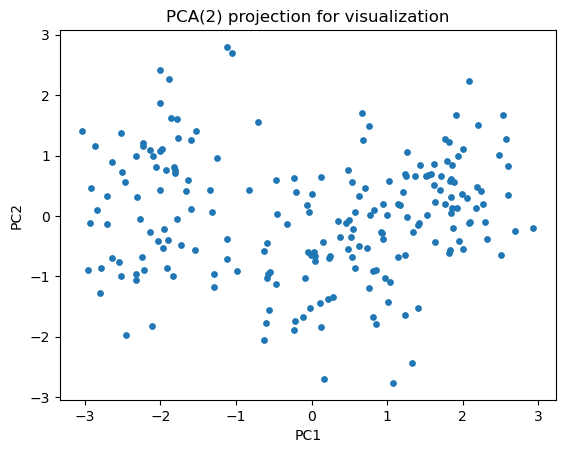

In [4]:
scaler = StandardScaler()
Z = scaler.fit_transform(df.values)

pca = PCA(n_components=2, random_state=42)
Z_pca2 = pca.fit_transform(Z)

print('Explained variance ratio (2 PCs):', np.round(pca.explained_variance_ratio_, 3))
plt.scatter(Z_pca2[:,0], Z_pca2[:,1], s=15)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('PCA(2) projection for visualization')
plt.show()

## 4) K-Means clustering
**Idea**: choose $k$ centers and assign each point to its nearest center to minimize the **within-cluster sum of squares**:
$$ J = \sum_{i=1}^{n} \min_{1 \le j \le k} \lVert x_i - \mu_j \rVert^2 $$

We sweep over several values of $k$ to inspect inertia and silhouette. The **elbow** suggests diminishing returns; the **silhouette** near 1 indicates well-separated clusters.


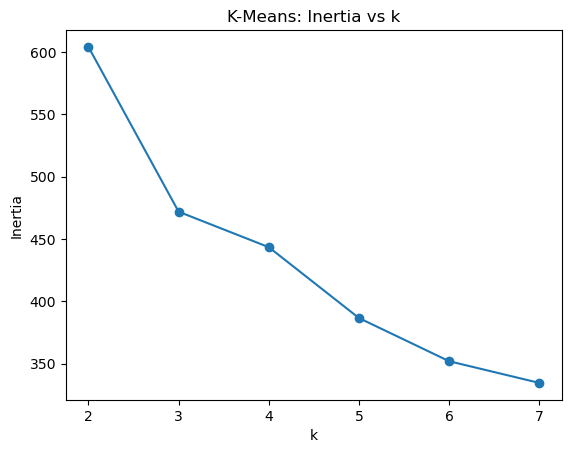

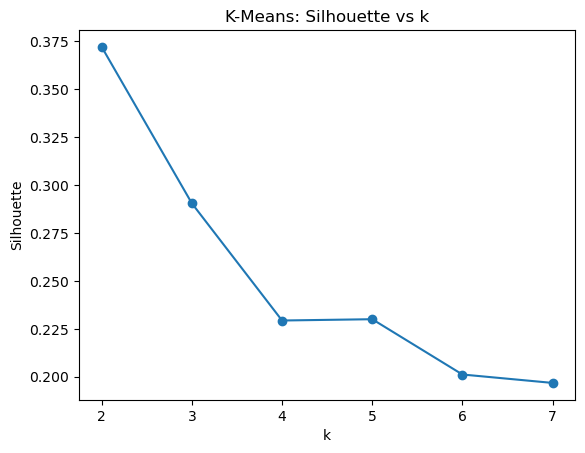

Best k by silhouette: 2


In [15]:
inertias = []
sils = []
ks = range(2, 8)
for k in ks:
    km = KMeans(n_clusters=k, n_init='auto', random_state=42)
    labels = km.fit_predict(Z)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(Z, labels))

fig, ax = plt.subplots()
ax.plot(list(ks), inertias, marker='o')
ax.set_xlabel('k'); ax.set_ylabel('Inertia'); ax.set_title('K-Means: Inertia vs k')
plt.show()

fig, ax = plt.subplots()
ax.plot(list(ks), sils, marker='o')
ax.set_xlabel('k'); ax.set_ylabel('Silhouette'); ax.set_title('K-Means: Silhouette vs k')
plt.show()

best_k = ks[int(np.argmax(sils))]
print('Best k by silhouette:', best_k)

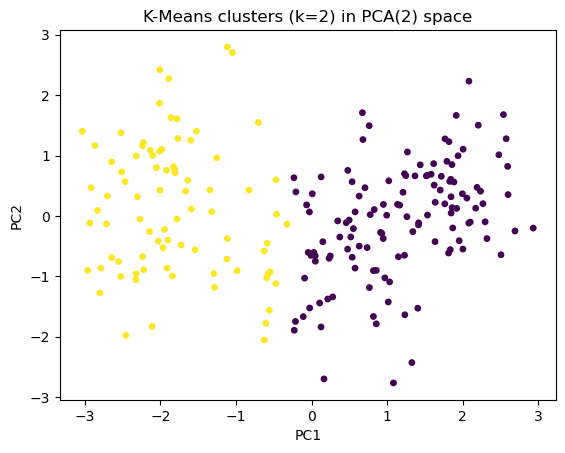

StudyHours        Attendance        SleepHours        LibraryVisits  \
              mean median       mean median       mean median          mean   
cluster                                                                       
0             8.72   8.89      89.21  90.30       7.29   7.35          3.96   
1             4.32   4.24      73.57  73.41       6.79   6.71          1.63   

               CafeSpend         
        median      mean median  
cluster                          
0         3.83     32.51  33.48  
1         1.66     42.11  41.96

In [6]:
# Fit final K-Means with chosen k (by silhouette)
k_final = int(ks[int(np.argmax(sils))])
kmeans = KMeans(n_clusters=k_final, n_init='auto', random_state=42)
km_labels = kmeans.fit_predict(Z)

# Plot clusters in PCA space
plt.scatter(Z_pca2[:,0], Z_pca2[:,1], c=km_labels, s=15)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title(f'K-Means clusters (k={k_final}) in PCA(2) space')
plt.show()

# Profiling: per-cluster means on original scale
km_profile = df.assign(cluster=km_labels).groupby('cluster').agg(['mean','median']).round(2)
km_profile

**Interpretation**
- Inspect per-cluster means and medians to understand each group.
- Use plain language labels such as **Focused**, **Balanced**, **At-risk**.
- Note how PCA spread supports cluster separation. PCA is not required for K-Means; we use it to make separation visible.


## 5) DBSCAN clustering
**Idea**: group points that are within a distance neighborhood of radius $\varepsilon$ with at least `min_samples` neighbors. Points not belonging to a dense region are labeled as **noise**.

**Parameters**
- $\varepsilon$ controls neighborhood radius.
- `min_samples` controls the minimum number of points to form a dense region.

We try a small grid and visualize results in PCA space.


In [7]:
eps_grid = [0.5, 0.7, 0.9, 1.1]
min_samps = [4, 6, 8]
results = []

for eps in eps_grid:
    for ms in min_samps:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(Z)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise_frac = np.mean(labels == -1)
        # For valid silhouette, need at least 2 clusters and not all noise
        sil = np.nan
        if n_clusters >= 2 and noise_frac < 1.0:
            sil = silhouette_score(Z, labels)
        results.append((eps, ms, n_clusters, noise_frac, sil))

res_df = pd.DataFrame(results, columns=['eps','min_samples','n_clusters','noise_frac','silhouette'])
display(res_df)

,eps,min_samples,n_clusters,noise_frac,silhouette
0,0.5,4,0,1.000000,NaN
1,0.5,6,0,1.000000,NaN
2,0.5,8,0,1.000000,NaN
3,0.7,4,7,0.719048,-0.264878
4,0.7,6,2,0.919048,-0.106969
5,0.7,8,1,0.961905,NaN
6,0.9,4,3,0.380952,0.002135
7,0.9,6,4,0.490476,-0.069492
8,0.9,8,3,0.609524,-0.094870
9,1.1,4,1,0.147619,NaN


Chosen eps, min_samples: 1.1 8


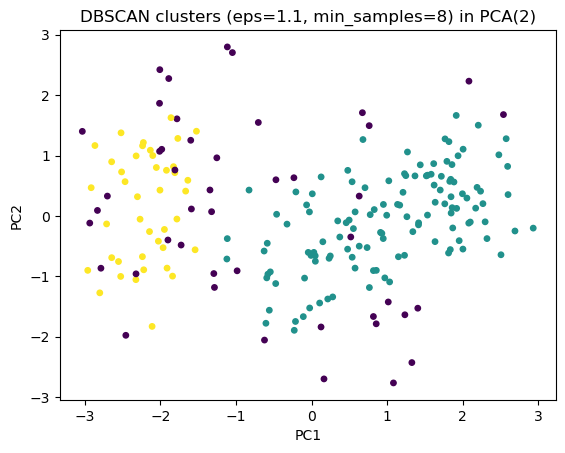

DBSCAN clusters: 2 ; noise fraction: 0.214


In [8]:
# Pick a reasonable DBSCAN setting: most clusters with modest noise and decent silhouette if available
cand = res_df.copy()
cand = cand.sort_values(by=['silhouette','n_clusters'], ascending=[False, False])
eps_best, ms_best = float(cand.iloc[0]['eps']), int(cand.iloc[0]['min_samples'])
print('Chosen eps, min_samples:', eps_best, ms_best)

db = DBSCAN(eps=eps_best, min_samples=ms_best)
db_labels = db.fit_predict(Z)

plt.scatter(Z_pca2[:,0], Z_pca2[:,1], c=db_labels, s=15)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title(f'DBSCAN clusters (eps={eps_best}, min_samples={ms_best}) in PCA(2)')
plt.show()

db_n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
db_noise = np.mean(db_labels == -1)
print('DBSCAN clusters:', db_n_clusters, '; noise fraction:', round(db_noise, 3))

**Interpretation**
- DBSCAN can label outliers as noise. If you see a nontrivial noise fraction, consider whether those points are atypical students.
- DBSCAN can reveal non-spherical shapes. If K-Means splits a banana-shaped group into two, DBSCAN may keep it intact.


## 6) Hierarchical (Agglomerative) clustering
**Idea**: start with each point as a cluster and iteratively merge the closest clusters. With Ward linkage, merges minimize variance increase.

We inspect a **dendrogram** and then choose a cut to obtain a small number of clusters.


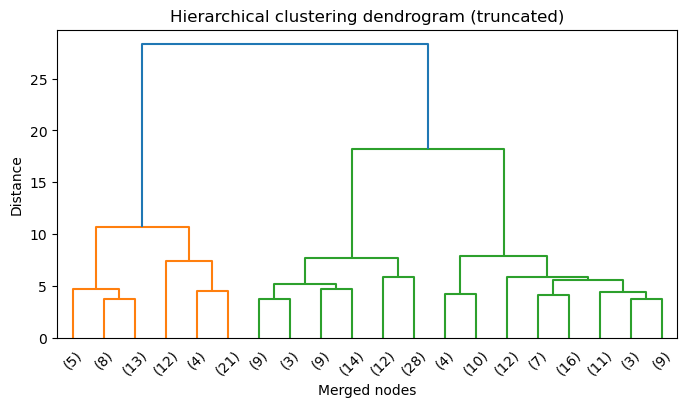

In [9]:
# Linkage on standardized data; Ward prefers Euclidean distance
Z_link = linkage(Z, method='ward')

plt.figure(figsize=(8, 4))
dendrogram(Z_link, truncate_mode='lastp', p=20, leaf_rotation=45, leaf_font_size=10)
plt.title('Hierarchical clustering dendrogram (truncated)')
plt.xlabel('Merged nodes'); plt.ylabel('Distance')
plt.show()

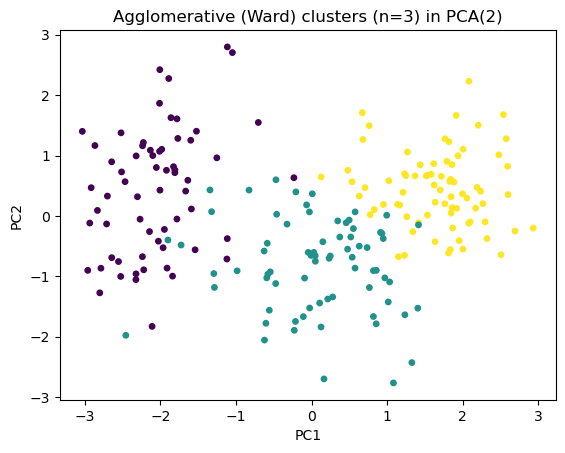

StudyHours        Attendance        SleepHours        LibraryVisits  \
              mean median       mean median       mean median          mean   
cluster                                                                       
0             4.08   4.03      72.70  72.49       6.78   6.70          1.51   
1             6.73   6.92      82.87  83.70       6.83   6.86          2.94   
2             9.66   9.72      91.86  92.02       7.60   7.66          4.41   

               CafeSpend         
        median      mean median  
cluster                          
0         1.60     46.47  46.24  
1         2.98     27.73  27.94  
2         4.43     36.00  35.82

In [12]:
# Choose a cut that yields around 3 or 4 clusters
# We will cut at a distance chosen heuristically from the dendrogram structure.
# Alternatively, use 'maxclust' to set the number of clusters directly.
n_clusters_h = 3
agg = AgglomerativeClustering(n_clusters=n_clusters_h, linkage='ward')
agg_labels = agg.fit_predict(Z)

plt.scatter(Z_pca2[:,0], Z_pca2[:,1], c=agg_labels, s=15)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title(f'Agglomerative (Ward) clusters (n={n_clusters_h}) in PCA(2)')
plt.show()

agg_profile = df.assign(cluster=agg_labels).groupby('cluster').agg(['mean','median']).round(2)
agg_profile

**Interpretation**
- The dendrogram shows merge distances; long vertical jumps suggest natural cuts.
- Compare the agglomerative clusters to K-Means. Are the profiles similar or do merges differ at the boundary cases?


## 7) Internal validation metrics
We compute three internal indices on the **final** clusters for each method:
- **Silhouette** in $[-1, 1]$ where higher is better.
- **Davies–Bouldin** where lower is better.
- **Calinski–Harabasz** where higher is better.


In [13]:
def safe_metrics(X_std, labels):
    # Some metrics require at least 2 clusters and not all points in one cluster
    if len(set(labels)) <= 1:
        return np.nan, np.nan, np.nan
    sil = silhouette_score(X_std, labels)
    dbi = davies_bouldin_score(X_std, labels)
    chi = calinski_harabasz_score(X_std, labels)
    return sil, dbi, chi

sil_km, dbi_km, chi_km = safe_metrics(Z, km_labels)
sil_db, dbi_db, chi_db = safe_metrics(Z, db_labels)
sil_ag, dbi_ag, chi_ag = safe_metrics(Z, agg_labels)

comp = pd.DataFrame({
    'Method': ['KMeans', 'DBSCAN', 'Agglomerative'],
    'Silhouette (higher)': [sil_km, sil_db, sil_ag],
    'Davies–Bouldin (lower)': [dbi_km, dbi_db, dbi_ag],
    'Calinski–Harabasz (higher)': [chi_km, chi_db, chi_ag]
}).round(3)

comp

,Method,Silhouette (higher),Davies–Bouldin (lower),Calinski–Harabasz (higher)
0,KMeans,0.372,1.091,153.514
1,DBSCAN,0.236,2.474,54.042
2,Agglomerative,0.284,1.247,121.504


## 8) Cluster profiling and naming
Pick the clustering you prefer based on metrics and interpretability; then profile and **name** the clusters.


In [14]:
# Choose the preferred labels to profile further (edit if you prefer DBSCAN or Agglomerative)
chosen_method = 'KMeans'
labels = km_labels

profile = df.assign(cluster=labels).groupby('cluster').agg(['mean','median']).round(2)
display(profile)

# Simple textual summary of cluster centers on original scale
centers = df.assign(cluster=labels).groupby('cluster').mean().round(2)
print('\nApproximate cluster means (original scale):\n')
print(centers)

StudyHours        Attendance        SleepHours        LibraryVisits  \
              mean median       mean median       mean median          mean   
cluster                                                                       
0             8.72   8.89      89.21  90.30       7.29   7.35          3.96   
1             4.32   4.24      73.57  73.41       6.79   6.71          1.63   

               CafeSpend         
        median      mean median  
cluster                          
0         3.83     32.51  33.48  
1         1.66     42.11  41.96


Approximate cluster means (original scale):

         StudyHours  Attendance  SleepHours  LibraryVisits  CafeSpend
cluster                                                              
0              8.72       89.21        7.29           3.96      32.51
1              4.32       73.57        6.79           1.63      42.11


**How to narrate clusters**
- Cluster 0: for example, high StudyHours and Attendance, moderate SleepHours, frequent LibraryVisits. Label it **Focused**.
- Cluster 1: moderate StudyHours and Attendance, balanced lifestyle. Label it **Balanced**.
- Cluster 2: lower StudyHours and Attendance, fewer LibraryVisits, higher CafeSpend. Label it **At-risk**.

Names should reflect patterns you would recognize in a real cohort.


## 9) Wrap-up and guidance
- **K-Means** is fast and works well with roughly spherical clusters. Choose $k$ with an elbow or silhouette.
- **DBSCAN** handles irregular shapes and marks outliers as noise. Requires tuning $\varepsilon$ and `min_samples`.
- **Hierarchical** yields a hierarchy of merges and does not require a fixed $k$ up front; choose a cut informed by the dendrogram.
- Always standardize when feature scales differ, and check that clusters make **domain sense**.

**Reflection prompt**: Looking at the profiling table, how would you advise each cluster to improve outcomes over the next month?
